# nurseCharting

The nurseCharting table is the largest table in eICU-CRD, and contains information entered in a semi-structured form by care staff. The three columns `nursingchartcelltypecat`, `nursingchartcelltypevallabel` and `nursingchartcelltypevalname` provide an organised structure for the data, but values entered in `nursingchartvalue` are free text entry and therefore fairly unstructured. Nurse charting data can be entered directy into the system or can represent interfaced data from charting in the bedside EMR.

At the moment, publicly available data for this table has been chosen based upon whether the information in `nursingchartvalue` is structured: data where this is highly structured has been made available (including scores such as the Glasgow Coma Scale or vital signs such as heart rate), conversely data where this is highly unstructured (free-text comments, nursing assessments) are not currently publicly available.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


## Examine a single patient

In [3]:
from sqlalchemy import create_engine
con= create_engine('postgresql://eicu@localhost:5432/eicu')

In [4]:
patientunitstayid = 141168

In [5]:
query = query_schema + """
select *
from nursecharting
where patientunitstayid = {}
order by nursingchartoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,nursingchartid,patientunitstayid,nursingchartoffset,nursingchartentryoffset,nursingchartcelltypecat,nursingchartcelltypevallabel,nursingchartcelltypevalname,nursingchartvalue
0,164546008,141168,6,6,Vital Signs,Heart Rate,Heart Rate,140
1,217584767,141168,6,6,Vital Signs,Non-Invasive BP,Non-Invasive BP Systolic,82
2,217584766,141168,6,6,Vital Signs,Non-Invasive BP,Non-Invasive BP Diastolic,59
3,169700483,141168,6,6,Other Vital Signs and Infusions,MAP (mmHg),Value,67
4,201844758,141168,6,6,Other Vital Signs and Infusions,Pulse Ox Mode,Value,Continuous


In [6]:
df.columns

Index(['nursingchartid', 'patientunitstayid', 'nursingchartoffset',
       'nursingchartentryoffset', 'nursingchartcelltypecat',
       'nursingchartcelltypevallabel', 'nursingchartcelltypevalname',
       'nursingchartvalue'],
      dtype='object')

In [7]:
# Look at a subset of columns
cols = ['nursingchartid','patientunitstayid',
        'nursingchartoffset','nursingchartentryoffset',
        'nursingchartcelltypecat', 'nursingchartcelltypevallabel',
        'nursingchartcelltypevalname', 'nursingchartvalue']
df[cols].head()

,nursingchartid,patientunitstayid,nursingchartoffset,nursingchartentryoffset,nursingchartcelltypecat,nursingchartcelltypevallabel,nursingchartcelltypevalname,nursingchartvalue
0,164546008,141168,6,6,Vital Signs,Heart Rate,Heart Rate,140
1,217584767,141168,6,6,Vital Signs,Non-Invasive BP,Non-Invasive BP Systolic,82
2,217584766,141168,6,6,Vital Signs,Non-Invasive BP,Non-Invasive BP Diastolic,59
3,169700483,141168,6,6,Other Vital Signs and Infusions,MAP (mmHg),Value,67
4,201844758,141168,6,6,Other Vital Signs and Infusions,Pulse Ox Mode,Value,Continuous


## Plot patient vitals over time

In [8]:
vitals = df['nursingchartcelltypevallabel'].value_counts()
vitals

nursingchartcelltypevallabel
Heart Rate                                        49
O2 Saturation                                     33
Pulse Ox  Mode                                    31
Temperature                                       24
Non-Invasive BP                                   14
Mental Status Assessment                          11
MAP (mmHg)                                        10
Invasive BP                                       10
Pain Score/Goal                                   10
Respiratory Rate                                   8
Integumentary Assessment                           8
Gastrointestinal Assessment                        8
Pain Assessment                                    8
Respiratory Assessment                             8
Musculoskeletal Assessment                         8
Patient s Comfort/Function (Pain) GOAL At Rest     8
Eye, Ear, Nose, Throat Assessment                  8
CV/ PV Assessment                                  8
Neurological Asse

/var/folders/0y/54ttk0rd3vdgxkwlwgxb5h0m0000gn/T/ipykernel_26081/2391137024.py:24: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(df_plot['nursingchartoffset'],


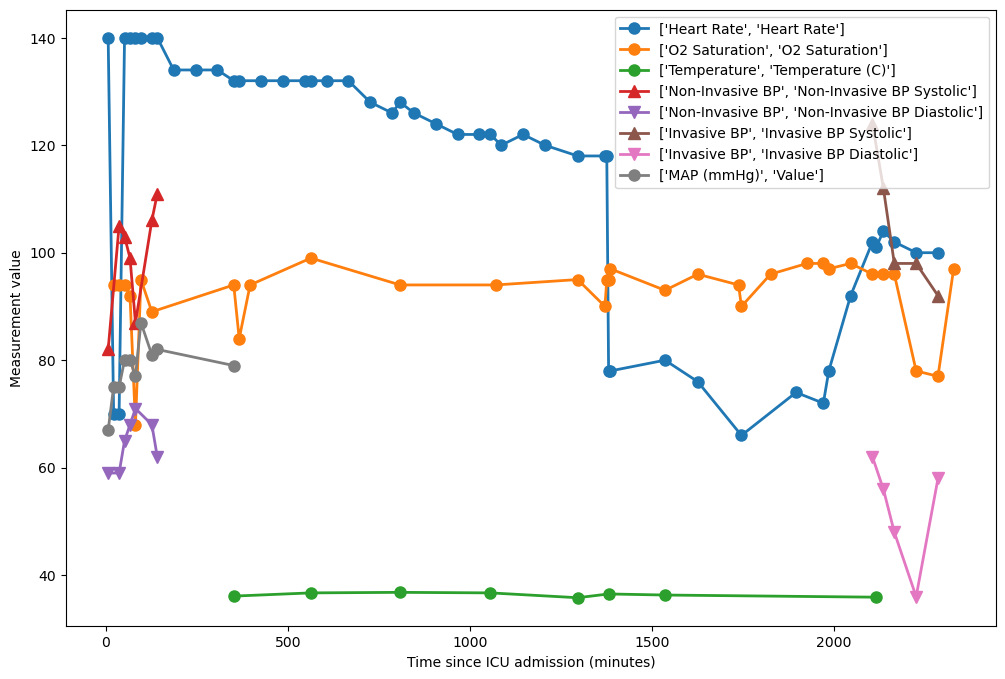

In [9]:
# list of lists
# for each element, the list is:
#   [nursingchartcelltypevallabel, nursingchartcelltypevalname]
vitals = [['Heart Rate','Heart Rate'],
          ['O2 Saturation','O2 Saturation'],
          ['Temperature','Temperature (C)'],
          ['Non-Invasive BP','Non-Invasive BP Systolic'],
          ['Non-Invasive BP','Non-Invasive BP Diastolic'],
          ['Invasive BP','Invasive BP Systolic'],
          ['Invasive BP','Invasive BP Diastolic'],
          ['MAP (mmHg)','Value']]

plt.figure(figsize=[12,8])
for v in vitals:
    idx = (df['nursingchartcelltypevallabel'] == v[0]) & (df['nursingchartcelltypevalname'] == v[1])
    df_plot = df.loc[idx, :]
    
    if 'Systolic' in v[1]:
        marker = '^-'
    elif 'Diastolic' in v[1]:
        marker = 'v-'
    else:
        marker = 'o-'
    plt.plot(df_plot['nursingchartoffset'],
             pd.to_numeric(df_plot['nursingchartvalue'], errors='coerce'),
            marker, markersize=8, lw=2, label=v)
    
plt.xlabel('Time since ICU admission (minutes)')
plt.ylabel('Measurement value')
plt.legend(loc='upper right')
plt.show()

## Hospitals with data available

In [10]:
query = query_schema + """
with t as
(
select distinct patientunitstayid
from nursecharting
)
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct t.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join t
  on pt.patientunitstayid = t.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
11,73,7059,7003,99.206686
54,167,6092,5887,96.634931
106,264,5237,5199,99.274394
184,420,4679,4457,95.255396
134,338,4277,4246,99.275193
90,243,4243,4186,98.656611
71,199,4240,4180,98.584906
58,176,4328,4136,95.563771
206,458,3701,3653,98.703053
200,443,3656,3625,99.152079


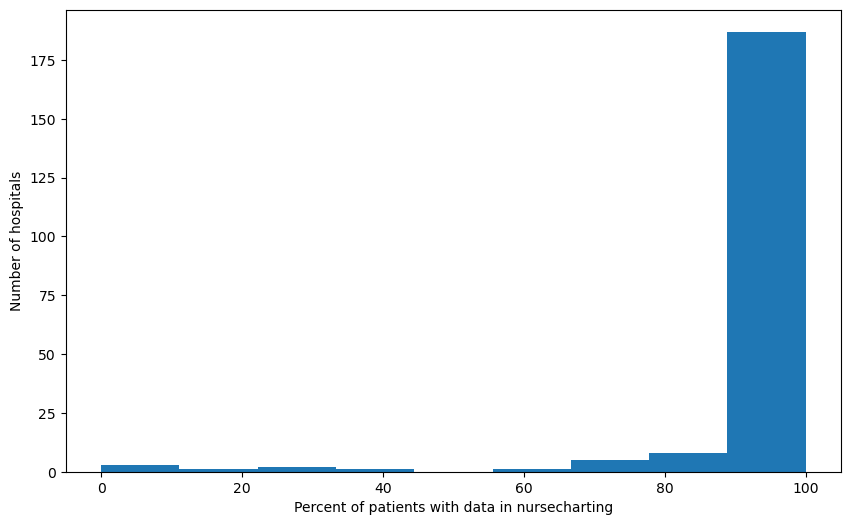

In [11]:
plt.figure(figsize=[10,6])
plt.hist(df['data completion'], bins=np.linspace(0, 100, 10))
plt.xlabel('Percent of patients with data in nursecharting')
plt.ylabel('Number of hospitals')
plt.show()

As is common in eICU-CRD, there are a subset of hospitals who routinely utilize this portion of the medical record (and thus have 90-100% data completion), while there are other hospitals who rarely use this interface and thus have poor data completion (0-10%).